In [15]:
import math
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [16]:
utopia_data = pd.read_excel('Data-Project2-Fall2022.xlsx',
                       index_col= 2, sheet_name=0, skiprows=[1,42,43])
utopia_data

,Link,Link.1,Length,Number of lanes,Free-flow speed (mph),Capacity,Link's addition expense (money unit per lane),Link's demolition savings(money unit per lane)
Link.2,,,,,,,,
1,1,8,1.0,2,50,1800,1.0,0.50
2,3,9,1.5,2,50,1800,1.5,0.75
3,4,10,1.5,2,50,1800,1.5,0.75
4,5,11,1.5,2,50,1800,1.5,0.75
5,6,12,1.0,2,50,1800,1.0,0.50
6,8,9,1.0,1,50,1800,1.0,0.50
7,9,10,1.0,1,50,1800,1.0,0.50
8,10,11,1.0,1,50,1800,1.0,0.50
9,11,12,1.0,1,50,1800,1.0,0.50


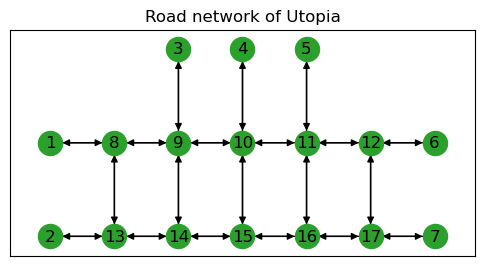

In [17]:
utp = nx.from_pandas_edgelist(utopia_data,
                             source='Link',target='Link.1', # 'Link' and 'Link.1' represent 'Tail' and 'Head'
                             edge_attr=('Number of lanes','Length'),
                             create_using=nx.DiGraph())                           
utp.add_node(1, loc = (1,2))
utp.add_node(2, loc = (1,1))
utp.add_node(3, loc = (3,3))
utp.add_node(4, loc = (4,3))
utp.add_node(5, loc = (5,3))
utp.add_node(6, loc = (7,2))
utp.add_node(7, loc = (7,1))
utp.add_node(8, loc = (2,2))
utp.add_node(9, loc = (3,2))
utp.add_node(10, loc = (4,2))
utp.add_node(11, loc = (5,2))
utp.add_node(12, loc = (6,2))
utp.add_node(13, loc = (2,1))
utp.add_node(14, loc = (3,1))
utp.add_node(15, loc = (4,1))
utp.add_node(16, loc = (5,1))
utp.add_node(17, loc = (6,1))


pos = nx.get_node_attributes(utp,'loc')
lanes =  nx.get_edge_attributes(utp,'Number of lanes')
lengths =  nx.get_edge_attributes(utp,'Length')

freespeed = 50
capacity_lane = 1800 

freetime = {}
for key in lengths.items():
    freetime[key[0]]=key[1]/freespeed*60 # (in min)
    
capacity = {}
for key in lanes.items():
    capacity[key[0]]=key[1]*capacity_lane


edgelist = list(utp.edges()) # links 
nodelist = list(utp.nodes()) # nodes

plt.figure(figsize = (6,3), dpi = 100)
nx.draw_networkx(utp, pos, node_color="tab:green", arrows= True, with_labels  = True)

plt.title("Road network of Utopia")
plt.show()

In [18]:
ODs = [[1,6],[1,7],[2,6],[2,7],[3,6],[3,7],[4,6],[4,7],[5,6],[5,7],[6,1],[6,2],[7,1],[7,2]]

demand = {1: {6: 500, 7: 500}, # 2025yr demand
         2: {6: 500, 7: 500},
         3: {6: 500, 7: 500},
         4: {6: 500, 7: 500},
         5: {6: 500, 7: 500},
         6: {1: 500, 2: 500},
         7: {1: 500, 2: 500}}
'''
demand = {1: {6: 1000, 7: 1000},  # 2035yr demand
         2: {6: 1000, 7: 1000},
         3: {6: 800, 7: 800},
         4: {6: 800, 7: 800},
         5: {6: 600, 7: 600},
         6: {1: 1000, 2: 1000},
         7: {1: 1000, 2: 1000}}
'''

'\ndemand = {1: {6: 1000, 7: 1000},  # 2035yr demand\n         2: {6: 1000, 7: 1000},\n         3: {6: 800, 7: 800},\n         4: {6: 800, 7: 800},\n         5: {6: 600, 7: 600},\n         6: {1: 1000, 2: 1000},\n         7: {1: 1000, 2: 1000}}\n'

In [19]:
# Link performance
def t_ij(t0, flow, ca): 
    return t0*(1+0.15*(flow/ca)**4)

# z to minimize for UE
def z_ue(t0, flow, ca): 
    return t0*(flow+0.03*np.power(flow,5)/(np.power(ca,4))) 

In [20]:
# Bisection Algorithm for UE
def bisection_ue(xa_n, ya_n, edgelist, time, capacity):        
    
    def LineSearch(alpha): # Solving '(y^n-x^n)*deltaZ(x^n+alpha(y^n-x^n)) = 0'
        LineSearch = 0
        for i in range(len(edgelist)):
            edge_i = edgelist[i]
            direction_i = ya_n[edge_i] - xa_n[edge_i] # y^n-x^n
            xa_updated_alpha = xa_n[edge_i] + alpha * direction_i # x^n  + alpha * (y^n-x^n)
            LineSearch+=direction_i*time[edge_i]*(1+0.15*(xa_updated_alpha/capacity[edge_i])**4)           
        return LineSearch

    a = 0
    b = 1        

    m = (a+b)/2
    
    while (np.abs(a-b)) >= 0.000000001: 
        if np.sign(LineSearch(m))<0:
            a = m
        else:
            b = m
        m = (a+b)/2
    
    return m

In [21]:
# All-or-nothing Algorithm for UE and SO
def allnothing(ta_n):
    utp = nx.DiGraph()
    utp.add_weighted_edges_from((u, v, ta_n[(u,v)]) for u,v in edgelist)
    
    # Finds the shortest path from node to node
    #allpath = dict(nx.all_pairs_bellman_ford_path(utp, weight='weight')) # Check weight='Length'
    allpath = dict(nx.all_pairs_bellman_ford_path(utp, weight='Length')) # Check weight='Length'
    
    # Get paths connecting O-D pairs not contained in ODs       
    OD_removed = []
    for i in allpath.keys():
        for j in allpath[i]:
            if [i,j] not in ODs:
                OD_removed.append([i,j])
    
    # Excluding the paths to remove above
    for k in OD_removed:
        del allpath[k[0]][k[1]]
    
    ya_n = {(u,v): float(0) for u,v in edgelist}
    
    for k in range(len(ODs)): # Iterate what comes below for all O-D pairs,
        path_starting_at = ODs[k][0]
        path_ending_at = ODs[k][1]
        ODpath = allpath[path_starting_at][path_ending_at] # get the shortest path, 
        links_onODpath = []
        
        if len(ODpath) > 1:
            for j in range(len(ODpath)-1):
                link_starting_at = ODpath[j] 
                link_ending_at = ODpath[j+1]               
                link_element = [link_starting_at,link_ending_at] # [[node i, node i+1],[node i+1, node i+2],...]
                links_onODpath.append(link_element) # and get links on the on he shortest path.
            
        for i in range(len(links_onODpath)):
            #and for the links found, sum up corresponding demand
            #print(ODs[k])
            #print((links_onODpath[i][0],links_onODpath[i][1]))
            #print(demand[ODs[k][0]][ODs[k][1]])
            ya_n[(links_onODpath[i][0],links_onODpath[i][1])] += demand[ODs[k][0]][ODs[k][1]]
    
    return ya_n
    

In [22]:
xa = allnothing(freetime) 
error = 100
xa_old = xa
print(freetime)
print(xa)

{(1, 8): 1.2, (8, 9): 1.2, (8, 13): 1.7999999999999998, (8, 1): 1.2, (3, 9): 1.7999999999999998, (9, 10): 1.2, (9, 14): 1.7999999999999998, (9, 3): 1.7999999999999998, (9, 8): 1.2, (4, 10): 1.7999999999999998, (10, 11): 1.2, (10, 15): 1.7999999999999998, (10, 4): 1.7999999999999998, (10, 9): 1.2, (5, 11): 1.7999999999999998, (11, 12): 1.2, (11, 16): 1.7999999999999998, (11, 5): 1.7999999999999998, (11, 10): 1.2, (6, 12): 1.2, (12, 17): 1.7999999999999998, (12, 6): 1.2, (12, 11): 1.2, (13, 14): 1.2, (13, 8): 1.7999999999999998, (13, 2): 1.2, (14, 15): 1.2, (14, 9): 1.7999999999999998, (14, 13): 1.2, (15, 16): 1.2, (15, 10): 1.7999999999999998, (15, 14): 1.2, (16, 17): 1.2, (16, 11): 1.7999999999999998, (16, 15): 1.2, (17, 12): 1.7999999999999998, (17, 16): 1.2, (17, 7): 1.2, (2, 13): 1.2, (7, 17): 1.2}
{(1, 8): 1000.0, (8, 9): 1000.0, (8, 13): 0.0, (8, 1): 1000.0, (3, 9): 1000.0, (9, 10): 2000.0, (9, 14): 0.0, (9, 3): 0.0, (9, 8): 1000.0, (4, 10): 1000.0, (10, 11): 3000.0, (10, 15): 0.0

In [23]:
  
while error >= 0.0005: 
    
    # Obtain t_a
    ta_new = {(u,v): t_ij(freetime[(u,v)], xa_old[(u,v)], capacity[(u,v)]) for u,v in edgelist}
    
    # Obtain y_a (Direct finding)
    ya = allnothing(ta_new)
    #allpath = allnothing(ta_new)[1]
       
    # Obtain alpha_n (Line search)
    alpha = bisection_ue(xa_old, ya, edgelist, freetime, capacity)
    
    # Obtain new x_a
    xa_new = {(u,v): xa_old[(u,v)] + alpha*( ya[(u,v)]-xa_old[(u,v)] ) for u,v in edgelist}

    # Obtain epsilon for convergence test
    eij = {(u,v):( xa_old[(u,v)]-xa_new[(u,v)] )**2 for u,v in edgelist}
    error = np.sqrt(sum(eij.values()))/sum(xa_old.values())
                 
    xa_old = xa_new

In [24]:
def tsij(t0,flow,ca):
    return t0*(1+0.15*(flow/ca)**4)*flow

Zij = { (u,v): z_ue( freetime[(u,v)], xa_new[(u,v)], capacity[(u,v)] ) for u,v in edgelist} 
Z = sum(Zij.values())

tsij_result = { (u,v): tsij( freetime[(u,v)], xa_new[(u,v)], capacity[(u,v)] ) for u,v in edgelist}
T = sum(tsij_result.values())

In [25]:
print('Result')
print('Objective Z = ' + str(Z))
print('System T :' + str(T))
print('Error = ' + str(error))

Result
Objective Z = 56350.9178883745
System T :76554.58944187243
Error = 0.0


In [26]:
UE = pd.DataFrame.from_dict(xa_new,
                            orient='index',
                            columns=['UE_flow'])

UE['ca(veh/link)'] = capacity.values()
UE['ta^0(min)'] = freetime.values()
UE['UE_tt'] = UE['ta^0(min)']*(1+0.15*(UE['UE_flow']/UE['ca(veh/link)'])**4)
UE['v/c'] = UE['UE_flow']/UE['ca(veh/link)']
UE

,UE_flow,ca(veh/link),ta^0(min),UE_tt,v/c
"(1, 8)",1000.0,3600,1.2,1.201072,0.277778
"(8, 9)",1000.0,1800,1.2,1.217147,0.555556
"(8, 13)",0.0,1800,1.8,1.800000,0.000000
"(8, 1)",1000.0,3600,1.2,1.201072,0.277778
"(3, 9)",1000.0,3600,1.8,1.801608,0.277778
"(9, 10)",2000.0,1800,1.2,1.474348,1.111111
"(9, 14)",0.0,1800,1.8,1.800000,0.000000
"(9, 3)",0.0,3600,1.8,1.800000,0.000000
"(9, 8)",1000.0,1800,1.2,1.217147,0.555556
"(4, 10)",1000.0,3600,1.8,1.801608,0.277778
